# SuAVE Image to Label Prediction Model

In [1]:
%%javascript
function getQueryStringValue (key)
{  
    return unescape(window.location.search.replace(new RegExp("^(?:.*[&\\?]" + escape(key).replace(/[\.\+\*]/g, "\\$&") + "(?:\\=([^&]*))?)?.*$", "i"), "$1"));
}
IPython.notebook.kernel.execute("survey_url='".concat(getQueryStringValue("surveyurl")).concat("'"));
IPython.notebook.kernel.execute("user='".concat(getQueryStringValue("user")).concat("'"));
IPython.notebook.kernel.execute("csv_file='".concat(getQueryStringValue("csv")).concat("'")); 
IPython.notebook.kernel.execute("dzc_file='".concat(getQueryStringValue("dzc")).concat("'")); 
IPython.notebook.kernel.execute("params='".concat(getQueryStringValue("params")).concat("'")); 
IPython.notebook.kernel.execute("active_object='".concat(getQueryStringValue("activeobject")).concat("'")); 

<IPython.core.display.Javascript object>

In [67]:
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from imutils import paths

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras import backend as K

In [4]:
# More imports
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import csv
import pandas as pd
import re
import cv2
import os

In [68]:
# import the necessary packages for SVM predictor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import imutils
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

In [5]:
# Import widget functionality
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## This notebook uses the LeNet model for prediction

In [6]:
class LeNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# first set of CONV => RELU => POOL layers
		model.add(Conv2D(64, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# second set of CONV => RELU => POOL layers
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
		# third set of CONV => RELU => POOL layers
		model.add(Conv2D(256, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
              
		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1000))
		model.add(Activation("relu"))
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

### Initializing the number of times the model will loop for learning

In [7]:
# init the number of epochs to train for, init learning rate and batch size
EPOCHS = 50
INIT_LR = 1e-3
BS = 64

In [8]:
# init the image suffix, yset, and image list
suffix = '.jpg'
img_list = []
yset = []
# create labels list and 2 dicts for 2 way mapping
labels = []
# key = label value = number
label_yval = dict()
# key = number value = label
yval_label = dict()

In [9]:
# Testing Cells
csv_file = 'zaslavsk_Cyclops_Cave_Ceramic_Petrography.csv'

In [10]:
# use csv file to grab images/labels
df = pd.read_csv(csv_file)

In [11]:
toImg = list(df.columns.values)

img_menu = {}
for i in range(0, len(toImg)):
    img_menu[toImg[i]] = toImg[i]

def f(images_menu):
    return images_menu

## Run and choose the column name that coresponds with the Image column in the CSV

### Then run next cell

In [12]:
out = interact(f, images_menu=img_menu)

A Jupyter Widget

In [13]:
# Choose column of label for prediction
toPredict = list(df.columns.values)

pred_menu = {}
for i in range(0, len(toPredict)):
    pred_menu[toPredict[i]] = toPredict[i]

def f(predictions_menu):
    return predictions_menu

## Run and choose the column name that coresponds with the column lable to be predicted

### Then run next cell

In [14]:
out2 = interact(f, predictions_menu=pred_menu)

A Jupyter Widget

In [15]:
nameCol = df[out.widget.result]
predCol = df[out2.widget.result]

In [16]:
# add all fabric columns to the y set
for i in range (0,len(predCol)):
    labels.append(predCol[i])

In [17]:
# grab all unique labels
uni_labels = set(labels)
uni_labels = list(uni_labels)

In [18]:
# assign each label a dict key number
for i in range(0,len(uni_labels)):
    yval_label[i] = uni_labels[i]
    label_yval[uni_labels[i]] = i

In [19]:
print("Number of labels to learn from: " + str(len(labels)))

Number of labels to learn from: 252


In [20]:
# create list of keys associated with their labels
for i in range (0, len(labels)):
    yset.append(label_yval[labels[i]])

In [21]:
# gather images from path created from file names in csv file
for i in range (0,len(nameCol)):
    base_filename = nameCol[i]
    fileName = os.path.join("./Cyclops Cave/images/", base_filename + suffix)
    im = cv2.imread(fileName)
    im = cv2.resize(im, (28,28))
    im = img_to_array(im)
    img_list.append(im)

## SVM learning algorithm

In [69]:
def extract_color_histogram(image, bins=(8,8,8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of 'bins' per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins, [0,180,0,256,0,256])
    
    # handle normalizing the histogram if we are using OpenCV 2.4.X
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    
    # otherwise, perform "in place" normaliation in OpenCV 3
    else:
        cv2.normalize(hist, hist)
    
    return hist.flatten()

In [70]:
# create new hist_list
hist_list = []

In [71]:
# gather images from path created from file names in csv file
for i in range (0,len(nameCol)):
    base_filename = nameCol[i]
    fileName = os.path.join("./Cyclops Cave/images/", base_filename + suffix)
    im = cv2.imread(fileName)
    hist = extract_color_histogram(im)
    hist_list.append(hist)

In [73]:
np.shape(hist_list)

(252, 512)

In [60]:
# Shuffle the data
p = np.random.permutation(len(yset))

In [61]:
# Relable for splitting sets
Y2 = []
X2 = []
for i in range(0,len(yset)):
    Y2.append(yset[p[i]])
    X2.append(hist_list[p[i]])

In [62]:
le = LabelEncoder()
labels = le.fit_transform(predCol)

In [63]:
(xtrain, xtest, ytrain, ytest) = train_test_split(np.array(hist_list),labels, test_size = 0.5)

In [64]:
le.classes_

array(['Cyclops Cave 1', 'Cyclops Cave 10', 'Cyclops Cave 11',
       'Cyclops Cave 12', 'Cyclops Cave 2', 'Cyclops Cave 3',
       'Cyclops Cave 4', 'Cyclops Cave 5', 'Cyclops Cave 6',
       'Cyclops Cave 7', 'Cyclops Cave 8', 'Cyclops Cave 9'], dtype=object)

In [65]:
# Train the linear regression classifier
model2 = LinearSVC()
model2.fit(xtrain, ytrain)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [66]:
# Calculate predictions on the data set
predictions2 = model2.predict(np.array(hist_list))
print(classification_report(labels, predictions2, target_names = le.classes_))

                 precision    recall  f1-score   support

 Cyclops Cave 1       0.69      0.99      0.81       144
Cyclops Cave 10       1.00      0.50      0.67         4
Cyclops Cave 11       0.33      0.25      0.29         4
Cyclops Cave 12       1.00      0.50      0.67         4
 Cyclops Cave 2       0.41      0.43      0.42        28
 Cyclops Cave 3       0.33      0.05      0.09        20
 Cyclops Cave 4       0.00      0.00      0.00        12
 Cyclops Cave 5       1.00      0.12      0.22         8
 Cyclops Cave 6       1.00      0.12      0.22         8
 Cyclops Cave 7       0.50      0.25      0.33         8
 Cyclops Cave 8       1.00      0.12      0.22         8
 Cyclops Cave 9       0.00      0.00      0.00         4

    avg / total       0.61      0.65      0.57       252



C:\Users\cinde\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
# Relable for splitting sets
Y = []
X = []
for i in range(0,len(yset)):
    Y.append(yset[p[i]])
    X.append(img_list[p[i]])

In [35]:
# split the test and training set 75:25
split = int(len(X)*(.75))
xtrain = X[:split]
xtest = X[split:]
ytrain = Y[:split]
ytest = Y[split:]

In [36]:
# transform to arrays
trainX = np.array(xtrain, dtype="float")/225.0
testX = np.array(xtest, dtype ="float")/225.0

ytrain = np.array(ytrain)
ytest = np.array(ytest)

In [37]:
# parsed Y data containers
trainY = []
testY = []

In [38]:
# convert labels from int to vectors
trainY = np_utils.to_categorical(ytrain,12)
testY = np_utils.to_categorical(ytest,12)

In [39]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                        horizontal_flip=True, fill_mode="nearest")

In [40]:
# initialize the model
print("[INFO] compiling model...")
model = LeNet.build(width=28, height=28, depth=3, classes=12)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
                metrics=["accuracy"])

[INFO] compiling model...


## Train the predictive model

### This is relative to the size of the data set and may take a few minutes 

In [41]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)

[INFO] training network...
Epoch 1/50
3/2 [=============================================] - 3s 1s/step - loss: 1.9963 - acc: 0.4588 - val_loss: 1.8355 - val_acc: 0.5873
Epoch 2/50
3/2 [=============================================] - 2s 656ms/step - loss: 1.6748 - acc: 0.5630 - val_loss: 1.8309 - val_acc: 0.5873
Epoch 3/50
3/2 [=============================================] - 2s 608ms/step - loss: 1.6357 - acc: 0.5712 - val_loss: 1.7952 - val_acc: 0.5873
Epoch 4/50
3/2 [=============================================] - 2s 615ms/step - loss: 1.6504 - acc: 0.5588 - val_loss: 1.7183 - val_acc: 0.5873
Epoch 5/50
3/2 [=============================================] - 2s 617ms/step - loss: 1.6495 - acc: 0.5610 - val_loss: 1.7018 - val_acc: 0.5873
Epoch 6/50
3/2 [=============================================] - 2s 621ms/step - loss: 1.6286 - acc: 0.5651 - val_loss: 1.6743 - val_acc: 0.5873
Epoch 7/50
3/2 [=============================================] - 2s 628ms/step - loss: 1.5468 - acc: 0.567

## Plot the loss and accuracy

In [42]:
# plot the training loss and accuracy 
plt.style.use("ggplot")
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Label Prediction")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('figure.png')

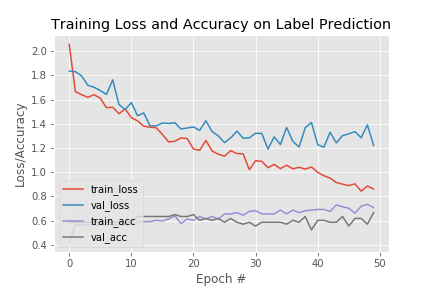

In [43]:
# Displays chart
from IPython.display import Image
Image("figure.png")

## Take the original data and predict based on the model

In [44]:
# Reshape original input data images for predicting
img_check = np.array(img_list, dtype ="float")/225.0

In [45]:
predictionsMade = []

In [46]:
preds = model.predict(img_check)

In [47]:
# Run all data through the prediction model that was created
for i in range (0,len(img_check)):
    predIndex = np.where(preds[i] == np.amax(preds[i]))
    prediction = int(predIndex[0][0])
    predictionsMade.append(prediction)

In [48]:
# Count how many correct predictions were made
correct = 0
for i in range (0,len(predictionsMade)):
    if(predictionsMade[i] == yset[i]):
        correct += 1 

## Calculate the accuracy of the predictions made

In [49]:
print("Accuracy: " + str(correct/len(yset)))

Accuracy: 0.7579365079365079


In [50]:
# Translate back to original csv label names
finalPred = []
for i in range (0,len(predictionsMade)):
    finalPred.append(yval_label[predictionsMade[i]])

## Enter a new header for the prediction column

In [51]:
from IPython.display import display
input_text = widgets.Text()
output_text = widgets.Text()

def bind_input_to_output(sender):
    output_text.value = input_text.value

input_text.on_submit(bind_input_to_output)

print("Input new column Header Label:")

display(input_text)

Input new column Header Label:


A Jupyter Widget

In [52]:
# Append the new column w/ it's new column name
df[input_text.value] = finalPred

## Write the predictions back to the original CSV

In [53]:
# new file name
new_file =  csv_file[:-4]+'_v1.csv'
df.to_csv(new_file, index=None)